In [25]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Add the directory where dynamics.py and utils.py are located to sys.path
module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm import tqdm
from dynamics import SatelliteDynamics
from scipy.linalg import block_diag
from utils import get_form_initial_conditions
from unkkt import UNKKT
from approxh_newton import approxH_Newton
from mm_newton import MM_Newton
from concurrent.futures import ProcessPoolExecutor

use_several_cpus = True

In [26]:
# Simulation parameters
dt = 60.0  # Time step [s]
T = 50  # Duration [min]
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6  # Number of states
n_p = 3  
n_y_1 = 3  # Number of measurements
n_y_2 = 2
n_y_3 = 2
n_y_4 = 2
K = T
W = T # Window size [min]
dynamic_model = SatelliteDynamics()

In [27]:
# Initial state vector and get the true state vectors (propagation) F
X_initial = get_form_initial_conditions(formation)
X_true = np.zeros((24, 1, T))
X_true[:, :, 0] = X_initial
for t in range(T - 1):
    X_true[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])

# Process noise
q_chief_pos = 1e-1  # [m]
q_chief_vel = 1e-2 # [m / s]
Q_chief = (
    np.diag(np.concatenate([q_chief_pos * np.ones(3), q_chief_vel * np.ones(3)]))
    ** 2
)
q_deputy_pos = 1e0  # [m]
q_deputy_vel = 1e-2  # [m / s]
Q_deputy = (
    np.diag(np.concatenate([q_deputy_pos * np.ones(3), q_deputy_vel * np.ones(3)]))
    ** 2
)
Q_deputies = block_diag(Q_deputy, Q_deputy, Q_deputy)
Q = block_diag(Q_chief, Q_deputies)

# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])

In [28]:
tol = 1e-20
max_iter = 100

# Declare solvers
unkkt = UNKKT(W, R_chief, r_deputy_pos)
unkkt.grad_tol = tol
unkkt.max_iter = max_iter

approxh_newton = approxH_Newton(W, R_chief, r_deputy_pos)
approxh_newton.grad_tol = tol
approxh_newton.max_iter = max_iter

mm_newton = MM_Newton(W, R_chief, r_deputy_pos)
mm_newton.grad_tol = tol
mm_newton.max_iter = max_iter
mm_newton.mm_tol = tol
mm_newton.mm_max_iter = 1

In [29]:
# Fixed seed for reproducibility
np.random.seed(42)

X_est = np.zeros_like(X_true)
initial_dev = np.concatenate(
    (
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
    )
)
X_est[:, :, 0] = X_initial + initial_dev
for t in range(T - 1):
    X_est[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_est[:, :, t])

# Observations
Y = np.zeros((9, 1, T))
for t in range(T):
    Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((9, 1)), size=(9, 1))
    
dev_chief_initial = np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).reshape(-1, 1)
dev_deputy1_initial = np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).reshape(-1, 1)
dev_deputy2_initial = np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).reshape(-1, 1)
dev_deputy3_initial = np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).reshape(-1, 1)

Windows:   0%|          | 0/1 [00:00<?, ?it/s]

-------- Centralized Newton ---------------- ApproxH Newton --------

-------- MM Newton --------

Majorization-Minimization Iteration 1
Before applying the algorithm
Cost function: 9312529.375134612
Gradient norm: 194592079.48173192
Global relative error: 395.60563949432424
Position relative errors: 82.78540989608044 m, 181.7491507333766 m, 258.73787052498585 m, 222.8729633755392 m

Before applying the algorithm
L_norm = 9312529.375134612
Grad_L_norm = 194592079.48173192

Iteration 1
Cost function: 435879.1222628716 (-95.32%)
Gradient norm: 7675601.370901629 (-96.06%)
Global relative error: 1074.0229370353043 (171.49%)
Position relative errors: 1.0702599767892143 m, 485.4927256884756 m, 396.56092543255176 m, 872.0999942346692 m

Before applying the algorithm
Cost function: 9312529.37513461
Gradient norm: 194592079.48173192
Global relative error: 395.60563949432424
Position relative errors: 82.78540989608044 m, 181.7491507333766 m, 258.73787052498585 m, 222.8729633755392 m

Iteration 1

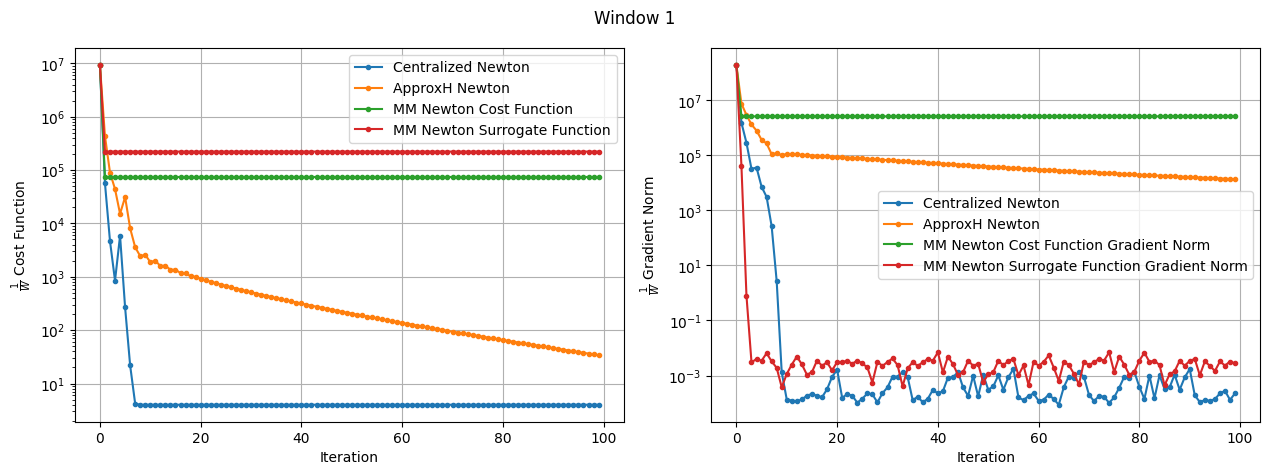


MC runs: 100%|██████████| 1/1 [02:38<00:00, 158.42s/it]


In [30]:
# DISTRIBUTED OVER SEVERAL CPUs
def solve_algorithm(algorithm_name, algorithm, X_est, dt, Y, X_true, n):
    """
    Solves the estimation problem for a given algorithm.
    Returns the algorithm name, updated X_est, and cost function/gradient data for plotting.
    """
    print(f"-------- {algorithm_name} --------")
    
    if algorithm_name == "Centralized Newton":
        X_est = algorithm.solve_for_each_window(dt, X_est, Y[:, :, n : n + W])
        final_errors = [
            np.linalg.norm(X_true[:3, :, n] - X_est[:3]),
            np.linalg.norm(X_true[6:9, :, n] - X_est[6:9]),
            np.linalg.norm(X_true[12:15, :, n] - X_est[12:15]),
            np.linalg.norm(X_true[18:21, :, n] - X_est[18:21])
        ]
        print(f"Final position relative errors: {final_errors} m")
    
    elif algorithm_name in ["ApproxH Newton", "MM Newton"]:
        X_est = algorithm.solve_for_each_window(dt, X_est, Y[:, :, n : n + W], X_true[:, :, n])

    # Collect cost function and gradient norm data
    return (
        algorithm_name,
        X_est,
        algorithm.cost_function_values.copy(),
        algorithm.grad_norm_values.copy(),
        algorithm.surrogate_function_values.copy() if hasattr(algorithm, "surrogate_function_values") else [],
        algorithm.surrogate_grad_norm_values.copy() if hasattr(algorithm, "surrogate_grad_norm_values") else []
    )

# ================= MAIN EXECUTION =================
for m in tqdm(range(M), desc="MC runs", leave=True):
    # Generate observations
    Y = np.zeros((9, 1, T))
    for t in range(T):
        Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.multivariate_normal(np.zeros(9), R).reshape((9, 1))

    # Initialize state estimates
    X_est_unkkt = X_initial + initial_dev
    X_est_approx_newton = X_initial + initial_dev
    X_est_mm = X_initial + initial_dev

    for n in tqdm(range(K - W + 1), desc="Windows", leave=False):
        with ProcessPoolExecutor(max_workers=3) as executor:
            # Run each algorithm in parallel
            future_to_algorithm = {
                executor.submit(solve_algorithm, "Centralized Newton", unkkt, X_est_unkkt, dt, Y, X_true, n): "Centralized Newton",
                executor.submit(solve_algorithm, "ApproxH Newton", approxh_newton, X_est_approx_newton, dt, Y, X_true, n): "ApproxH Newton",
                executor.submit(solve_algorithm, "MM Newton", mm_newton, X_est_mm, dt, Y, X_true, n): "MM Newton"
            }

            # Retrieve results in the main process
            results = {future.result()[0]: future.result()[1:] for future in future_to_algorithm}

        # Extract updated estimates
        X_est_unkkt, cost_unkkt, grad_unkkt, _, _ = results["Centralized Newton"]
        X_est_approx_newton, cost_approx, grad_approx, _, _ = results["ApproxH Newton"]
        X_est_mm, cost_mm, grad_mm, surrogate_cost_mm, surrogate_grad_mm = results["MM Newton"]

        # Plot results **in the main process**
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6.4, 4.8))

        # Cost function values
        ax1.plot(cost_unkkt, '.-', label='Centralized Newton')
        ax1.plot(cost_approx, '.-', label='ApproxH Newton')
        ax1.plot(cost_mm, '.-', label='MM Newton Cost Function')
        ax1.plot(surrogate_cost_mm, '.-', label='MM Newton Surrogate Function')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel(r'$\frac{1}{W}$ Cost Function')
        ax1.set_yscale('log')
        ax1.grid(True)
        ax1.legend()

        # Gradient norm values
        ax2.plot(grad_unkkt, '.-', label='Centralized Newton')
        ax2.plot(grad_approx, '.-', label='ApproxH Newton')
        ax2.plot(grad_mm, '.-', label='MM Newton Cost Function Gradient Norm')
        ax2.plot(surrogate_grad_mm, '.-', label='MM Newton Surrogate Function Gradient Norm')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel(r'$\frac{1}{W}$ Gradient Norm')
        ax2.set_yscale('log')
        ax2.grid(True)
        ax2.legend()

        fig.suptitle(f'Window {n + 1}')
        plt.tight_layout()
        plt.show()

        # Update state estimates
        X_est_unkkt = unkkt.dynamic_model.x_new(dt, X_est_unkkt)
        X_est_approx_newton = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton)
        X_est_mm = mm_newton.dynamic_model.x_new(dt, X_est_mm)


In [31]:
if not use_several_cpus:
    # SEQUENTIAL USING ONE CPU
    # Main execution loop
    for m in tqdm(range(M), desc="MC runs", leave=True):
        # Observations
        Y = np.zeros((9, 1, T))
        for t in range(T):
            Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.multivariate_normal(np.zeros(9), R).reshape((9, 1))
    
        # Estimate the state
        X_est_unkkt = X_initial + initial_dev
        X_est_approx_newton = X_initial + initial_dev
        X_est_mm = X_initial + initial_dev
        for n in tqdm(range(K - W + 1), desc="Windows", leave=False):
            print("-------- Centralized Newton --------")
            X_est_unkkt = unkkt.solve_for_each_window(dt, X_est_unkkt, Y[:, :, n : n + W])
            print(f"Final position relative errors: {np.linalg.norm(X_true[:3, :, n] - X_est_unkkt[:3])} m, {np.linalg.norm(X_true[6:9, :, n] - X_est_unkkt[6:9])} m, {np.linalg.norm(X_true[12:15, :, n] - X_est_unkkt[12:15])} m, {np.linalg.norm(X_true[18:21, :, n] - X_est_unkkt[18:21])} m")
            print("-------- ApproxH Newton --------")
            X_est_approx_newton = approxh_newton.solve_for_each_window(dt, X_est_approx_newton, Y[:, :, n : n + W], X_true[:, :, n])
            print("-------- MM Newton --------")
            X_est_mm = mm_newton.solve_for_each_window(dt, X_est_mm, Y[:, :, n : n + W], X_true[:, :, n])
    
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6.4, 4.8))
    
            # First subplot - Cost function values
            ax1.plot(unkkt.cost_function_values, '.-', label='Centralized Newton')
            ax1.plot(approxh_newton.cost_function_values, '.-', label='ApproxH Newton')
            ax1.plot(mm_newton.cost_function_values, '.-', label='MM Newton Cost Function')
            ax1.plot(mm_newton.surrogate_function_values, '.-', label='MM Newton Surrogate Function')
            ax1.set_xlabel('Iteration')
            ax1.set_ylabel('$\frac{1}{W}$ Cost Function')
            ax1.set_yscale('log')
            ax1.grid(True)
            ax1.legend()
    
            # Second subplot - Gradient norm values
            ax2.plot(unkkt.grad_norm_values, '.-', label='Centralized Newton')
            ax2.plot(approxh_newton.grad_norm_values, '.-', label='ApproxH Newton')
            ax2.plot(mm_newton.grad_norm_values, '.-', label='MM Newton Cost Function Gradient Norm')
            ax2.plot(mm_newton.surrogate_grad_norm_values, '.-', label='MM Newton Surrogate Function Gradient Norm')
            ax2.set_xlabel('Iteration')
            ax2.set_ylabel('$\frac{1}{W}$Gradient Norm')
            ax2.set_yscale('log')
            ax2.grid(True)
            ax2.legend()
    
            plt.title(f'Window {n + 1}')
            plt.tight_layout()
            plt.show()
            
            unkkt.cost_function_values = []
            unkkt.grad_norm_values = []
            approxh_newton.cost_function_values = []
            approxh_newton.grad_norm_values = []
            mm_newton.cost_function_values = []
            mm_newton.grad_norm_values = []
            mm_newton.surrogate_function_values = []
            mm_newton.surrogate_grad_norm_values = []
            
            X_est_unkkt = unkkt.dynamic_model.x_new(dt, X_est_unkkt)
            X_est_approx_newton = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton)
            X_est_mm = mm_newton.dynamic_model.x_new(dt, X_est_mm)